# Реранжирование в рекомендациях с помощью GDBT

## Импорты

In [1]:
import warnings
warnings.simplefilter('ignore')


import numpy as np
import pandas as pd
import shap


from lightgbm import LGBMRanker, LGBMClassifier
import pickle
from pathlib import Path
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns

from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple


## Подготовка данных

In [2]:
DATA_PATH = Path("data_original")

In [3]:
candidates = pd.read_csv('candidates_ranker.csv')


In [4]:
candidates

,user_id,item_id,lfm_score,lfm_rank,popular_score,popular_rank
0,176549,9728,4.125431,1,NaN,NaN
1,176549,12173,4.028789,2,10182.0,28.0
2,176549,13865,4.011769,3,93403.0,3.0
3,176549,7626,4.011071,4,NaN,NaN
4,176549,13018,3.934987,5,NaN,NaN
...,...,...,...,...,...,...
36043745,805174,12463,1.480902,46,7447.0,41.0
36043746,805174,7829,1.463453,47,6028.0,58.0
36043747,805174,6402,1.461368,48,7761.0,40.0
36043748,805174,12501,1.458890,49,7387.0,45.0


In [5]:
%%time
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')

CPU times: total: 1.05 s
Wall time: 2 s


### `interactions`: взаимодействия пользователь - айтем
- с датой `last_watch_dt`
- длительностью просмотра `total_dur`
- % просмотра `watched_pct`

In [6]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [7]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype('datetime64[ns]')

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0


### `users`: данные о пользователях

- `age` бин по возрасту
- `income` бин по доходу
- `sex` пол
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [8]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [9]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [10]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [11]:
# Наиболее популярны income - income_40_60
users.describe(include='category')

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


### `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова
- `description` - описание

In [12]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [13]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating',
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

## Трейн-вал-тест сплит


In [14]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


### Схема валидации с разбиением по юзерам

In [15]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)
# Для базовых моделей первого уровня (в нашем случае только lightfm)
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

In [16]:
base_models_data

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
...,...,...,...,...,...
5476242,268216,3071,2021-04-21,5752,98.0
5476243,497899,9629,2021-05-29,45,1.0
5476245,786732,4880,2021-05-12,753,0.0
5476247,546862,9673,2021-04-13,2308,49.0


## Скачиваем решение нашего первого уровня

In [17]:
# Считаем метрики первого уровня
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ),
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = calc_metrics_(candidates, 'lfm_rank')
models_metrics['lfm']
models_metrics['popular'] = calc_metrics_(candidates, "popular_rank")
pd.DataFrame(models_metrics)[["lfm", "popular"]]

,lfm,popular
Precision@10,0.024386,0.019285
recall@10,0.080970,0.065335
ndcg@10,0.029037,0.023902
map@10,0.037014,0.031254
novelty@10,3.177720,3.025827


## Формируем датасет для ранкера

### Генерим фичи для ранкера
 среди признаков ранкера есть хотя бы один, определяющий холодность пользователя (длина истории просмотров, общее время смотрения или что-либо еще)

In [18]:
# Вот эта фича отвечают у нас за холодность пользователя
# Получаем длину истории юзера
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)

# И Вот эта фича отвечают у нас за холодность пользователя
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)


In [19]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users,
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [20]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

### Джойним кандидатов и юзер/айтем фичи

In [21]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)],
        candidates_df[candidates_df['user_id'].isin(user_list)],
        how='right',
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    lfm_min_score: float =  df['lfm_score'].min() - 0.01
    lfm_max_rank: int = df['lfm_rank'].max() + 1  # 101
    pop_min_score: float =  df['popular_score'].min() - 0.01
    pop_max_rank: int = df['popular_rank'].max() + 1  # 101

    default_values = {
        'lfm_score': lfm_min_score,
        'lfm_rank': lfm_max_rank,
        'popular_score': pop_min_score,
        'popular_rank': pop_max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,popular_score,popular_rank
5866545,3,101,2021-07-01,0.0,0.0,1.696752,46,NaN,NaN
5866511,3,142,2021-08-13,5892.0,100.0,2.344714,12,35862.0,8.0
5866529,3,849,2021-07-01,0.0,0.0,1.922224,30,13304.0,26.0


In [22]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df,
        users,
        how='left',
        on=['user_id']
    )
    df = pd.merge(
        df,
        items,
        how='left',
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,popular_score,popular_rank,age,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,101,2021-07-01,0.0,0.0,1.696752,46,NaN,NaN,-1,...,0.0,11957.864865,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673
1,3,142,2021-08-13,5892.0,100.0,2.344714,12,35862.0,8.0,-1,...,0.0,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
2,3,849,2021-07-01,0.0,0.0,1.922224,30,13304.0,26.0,-1,...,0.0,11957.864865,2858.0,0,2018.0,-1,18.0,-1,13304.0,16.444678


## Обучаем ранкер

### Pairwise/Listwise

обучение ранкера

In [24]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [25]:
# Добавим таргет посложнее

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,popular_score,popular_rank,age,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker
0,3,101,2021-07-01,0.0,0.0,1.696752,46,NaN,NaN,-1,...,11957.864865,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0
1,3,142,2021-08-13,5892.0,100.0,2.344714,12,35862.0,8.0,-1,...,11957.864865,2858.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,2
2,3,849,2021-07-01,0.0,0.0,1.922224,30,13304.0,26.0,-1,...,11957.864865,2858.0,0,2018.0,-1,18.0,-1,13304.0,16.444678,0


In [26]:
# В train и val можно удалить 'плохих' пользователей,
# Например тех у кого слишком много или мало просмотров или
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу исправила на 50, тк в моделе первого уровня мы брали 50 а не 100

def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df,
        groups_df,
        how='left',
        on=['user_id']
    )
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df['group_size'] >= 50]

    # Колонка больше не нужна
    df.drop(columns=['group_size'], inplace=True)
    return df

# Исправляем баг, с outher join в users_filter
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['lfm_rank'] <= 50]

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

In [27]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'lfm_score', 'lfm_rank', 'popular_score', 'popular_rank',
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [28]:
early_stopping_rounds = 32
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

  File "C:\Users\11\anaconda3\envs\recsys\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.931788
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.225616
[LightGBM] [Debug] init for col-wise cost 0.072167 seconds, init for row-wise cost 0.110236 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 6760250, number of used features: 18
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
Training u

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [29]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.6966791047335386),
             ('ndcg@5', 0.7213956649690534),
             ('ndcg@10', 0.7461786205360688)])

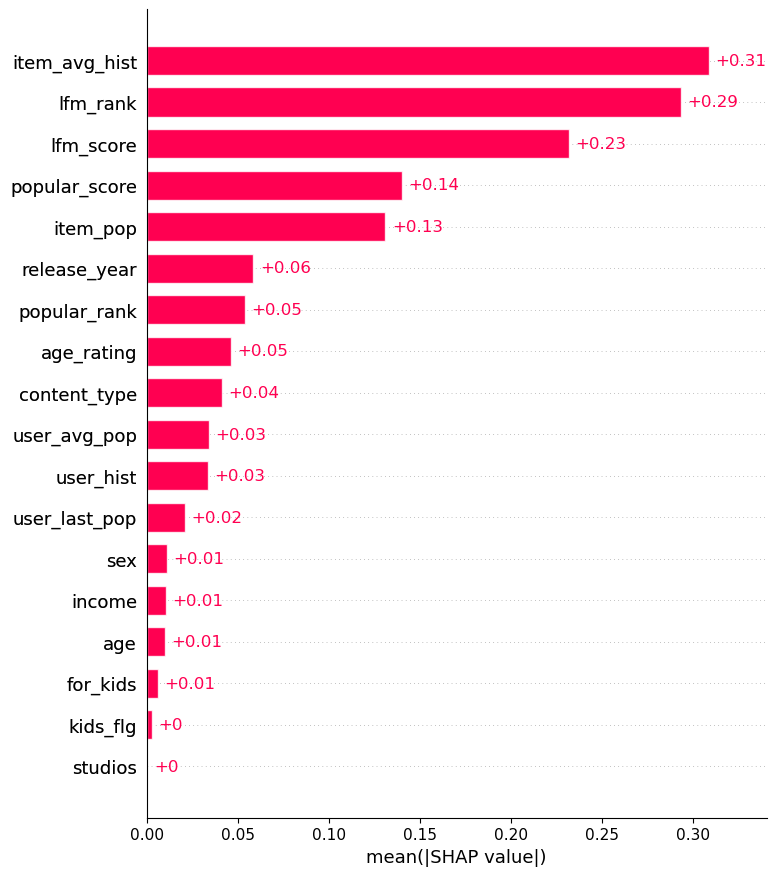

In [30]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

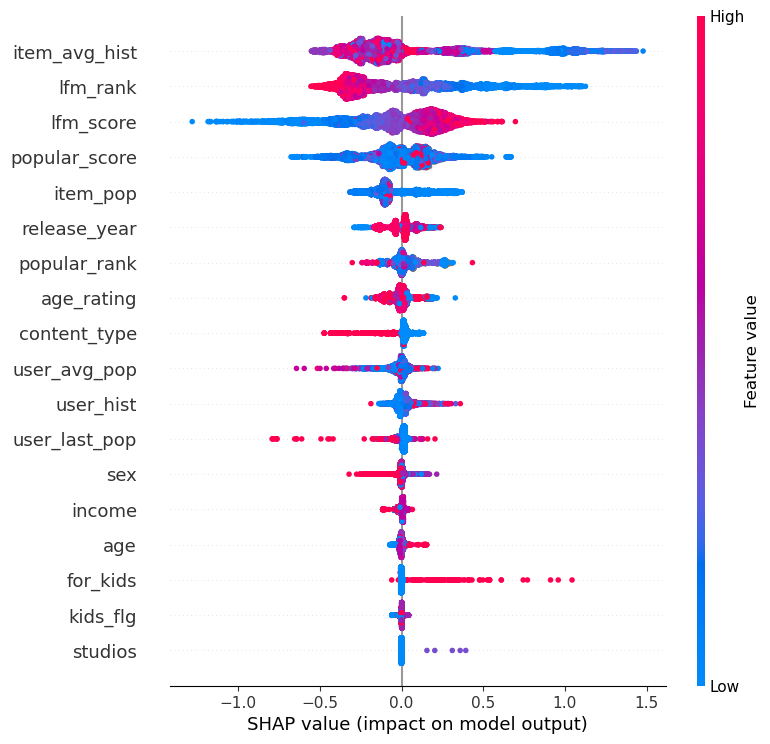

In [31]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

Модель очень сильно опирается на среднюю длину истории пользователя, а также на ранжирование с первого уровня. Возможно она переобучилась на данных с первого уровня.

In [32]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df['lfm_rank'] < 101).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 101
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df



In [33]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,popular_score,popular_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
29,53,9728,2021-07-01,0.0,0.0,3.342467,2,NaN,NaN,3,...,-1,18.0,-1,76978.0,11.165736,0,1.208644,1,1.208644,1
10,53,3734,2021-07-30,11529.0,100.0,3.094717,5,50004.0,6.0,3,...,-1,16.0,-1,50004.0,12.134949,2,0.857373,2,0.857373,2
47,53,15297,2021-07-01,0.0,0.0,3.165078,4,137128.0,2.0,3,...,-1,18.0,-1,137128.0,7.364295,0,0.600923,3,0.600923,3


In [45]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise']]

,listwise
Precision@10,0.027831
recall@10,0.092747
ndcg@10,0.034334
map@10,0.045991
novelty@10,3.415915


## Итоговые метрики
сравнение метрик двухэтапной модели и моделей первого уровня на тестовой выборке

In [46]:
pd.DataFrame(models_metrics)[['lfm', 'listwise']]

,lfm,listwise
Precision@10,0.024386,0.027831
recall@10,0.080970,0.092747
ndcg@10,0.029037,0.034334
map@10,0.037014,0.045991
novelty@10,3.177720,3.415915


# Save data

In [36]:
total_df = pd.concat([ranker_train,ranker_val, ranker_test])

In [37]:
total_df

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,popular_score,popular_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
0,3,101,2021-07-01,0.0,0.0,1.696752,46,NaN,NaN,-1,...,-1,18.0,-1,9542.0,17.990673,0,NaN,NaN,NaN,NaN
1,3,142,2021-08-13,5892.0,100.0,2.344714,12,35862.0,8.0,-1,...,-1,16.0,-1,35862.0,15.251464,2,NaN,NaN,NaN,NaN
2,3,849,2021-07-01,0.0,0.0,1.922224,30,13304.0,26.0,-1,...,-1,18.0,-1,13304.0,16.444678,0,NaN,NaN,NaN,NaN
3,3,1132,2021-07-01,0.0,0.0,1.716142,43,NaN,NaN,-1,...,-1,16.0,-1,9638.0,20.171612,0,NaN,NaN,NaN,NaN
4,3,1819,2021-07-01,0.0,0.0,2.063328,22,9792.0,30.0,-1,...,-1,16.0,-1,9792.0,14.719669,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441797,1097506,14741,2021-07-01,0.0,0.0,2.552383,20,19639.0,16.0,2,...,-1,16.0,-1,19639.0,15.725292,0,-2.063822,46.0,-2.063822,46.0
1441791,1097506,12981,2021-07-01,0.0,0.0,2.304082,38,9306.0,32.0,2,...,-1,16.0,-1,9306.0,22.071782,0,-2.158760,47.0,-2.158760,47.0
1441784,1097506,10464,2021-07-01,0.0,0.0,2.351179,30,9489.0,31.0,2,...,-1,16.0,-1,9489.0,21.203499,0,-2.169041,48.0,-2.169041,48.0
1441753,1097506,849,2021-07-01,0.0,0.0,2.448060,25,13304.0,26.0,2,...,-1,18.0,-1,13304.0,16.444678,0,-2.228328,49.0,-2.228328,49.0


In [38]:
# Делаем предсказания, проставляем ранги
y_pred: np.ndarray = listwise_model.predict(total_df[cols])
recos_full = add_score_and_rank(total_df, y_pred, "listwise")
recos_full.head()

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,popular_score,popular_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
47,3,15297,2021-07-01,0.0,0.0,2.897412,2,137128.0,2.0,-1,...,-1,18.0,-1,137128.0,7.364295,0,1.816231,1,1.816231,1
28,3,10440,2021-07-23,44827.0,90.0,2.920348,1,141889.0,1.0,-1,...,-1,18.0,-1,141889.0,8.068716,2,1.136631,2,1.136631,2
26,3,9728,2021-07-23,10448.0,100.0,2.780409,4,NaN,NaN,-1,...,-1,18.0,-1,76978.0,11.165736,2,1.066315,3,1.066315,3
10,3,3734,2021-07-01,0.0,0.0,2.687944,5,50004.0,6.0,-1,...,-1,16.0,-1,50004.0,12.134949,0,0.868669,4,0.868669,4
41,3,13865,2021-07-01,0.0,0.0,2.867758,3,93403.0,3.0,-1,...,-1,12.0,-1,93403.0,10.408520,0,0.711761,5,0.711761,5


In [39]:
n=10
recos_full = recos_full[[Columns.User, Columns.Item, 'listwise_hybrid_rank']]
recos_full = (
    recos_full.sort_values([Columns.User, 'listwise_hybrid_rank'])
    .groupby(Columns.User)
    .head(n)
)
recos_full.drop('listwise_hybrid_rank', axis=1,inplace=True)

In [40]:
recos_full

,user_id,item_id
47,3,15297
28,3,10440
26,3,9728
10,3,3734
41,3,13865
...,...,...
6760213,1097544,4151
6760249,1097544,16228
6760240,1097544,12192
6760229,1097544,7829


In [41]:
final_res = recos_full.copy()

In [42]:
final_res = final_res.explode('item_id')
final_res['rank'] = final_res.groupby('user_id').cumcount() + 1
final_res = final_res.groupby('user_id').agg({'item_id': list}).reset_index()
final_res = final_res.set_index('user_id')['item_id'].to_dict()

In [43]:
final_res

{3: [15297, 10440, 9728, 3734, 13865, 4151, 12192, 6809, 142, 8636],
 11: [15297, 10440, 9728, 3734, 12192, 13865, 4151, 142, 4495, 8636],
 14: [15297, 10440, 9728, 3734, 13865, 4151, 12192, 16228, 142, 8636],
 21: [9728, 15297, 3734, 10440, 13865, 4151, 4457, 7102, 142, 8636],
 30: [15297, 10440, 9728, 3734, 7829, 12192, 13865, 4151, 4495, 142],
 51: [9728, 13865, 15297, 10440, 3734, 4151, 7829, 4457, 7102, 8636],
 53: [9728, 3734, 15297, 10440, 13865, 4151, 4495, 142, 7102, 7829],
 55: [15297, 9728, 10440, 12192, 13865, 3734, 4151, 4495, 7829, 142],
 60: [9728, 3734, 13865, 15297, 10440, 4151, 7571, 4457, 8636, 142],
 65: [9728, 16166, 3734, 5411, 3182, 15297, 13865, 10440, 7571, 16270],
 75: [9728, 15297, 10440, 3734, 13865, 4151, 142, 6809, 12192, 8636],
 98: [15297, 10440, 9728, 3734, 13865, 4151, 12192, 142, 8636, 7829],
 106: [5411, 16166, 16270, 2954, 7582, 3182, 13243, 10761, 3734, 11749],
 107: [15297, 10440, 9728, 3734, 13865, 4151, 12192, 16228, 142, 8636],
 118: [9728, 152

In [44]:
with open('offline_ranker_lightfm.pkl', 'wb') as f:
    pickle.dump(final_res, f)
